<a href="https://colab.research.google.com/github/surabhipandey18/FoodAgri/blob/main/foodagri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import os

In [2]:
path = '/content/drive/MyDrive/Hackathon/Diseases'

In [3]:
def convert_to_rgba(path):
    try:
        img = Image.open(path)
        if img.mode == 'P' and 'transparency' in img.info:
            img = img.convert('RGBA')
        elif img.mode != 'RGBA' and img.mode != 'RGB': # Also convert other modes to RGBA
             img = img.convert('RGBA')
        return img
    except Exception as e:
        print(f"Error processing image {path}: {e}")
        return None

path = '/content/drive/MyDrive/Hackathon/Diseases' # Your image directory
preprocessed_path = '/content/drive/MyDrive/Hackathon/Diseases_preprocessed' # New directory for preprocessed images

# Create the preprocessed directory if it doesn't exist
if not os.path.exists(preprocessed_path):
    os.makedirs(preprocessed_path)

# Iterate through subdirectories (classes) and images
for class_name in os.listdir(path):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        preprocessed_class_path = os.path.join(preprocessed_path, class_name)
        if not os.path.exists(preprocessed_class_path):
            os.makedirs(preprocessed_class_path)

        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            converted_image = convert_to_rgba(image_path)
            if converted_image:
                # Save the converted image to the new directory
                save_path = os.path.join(preprocessed_class_path, image_name)
                try:
                    converted_image.save(save_path)
                except Exception as e:
                    print(f"Error saving image {save_path}: {e}")

Error saving image /content/drive/MyDrive/Hackathon/Diseases_preprocessed/maize fall armyworm/00000002.jpg: cannot write mode RGBA as JPEG
Error saving image /content/drive/MyDrive/Hackathon/Diseases_preprocessed/maize fall armyworm/00000075.jpg: cannot write mode RGBA as JPEG


In [4]:
training_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = training_generator.flow_from_directory(
    path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = training_generator.flow_from_directory(
    path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 11119 images belonging to 33 classes.
Found 2772 images belonging to 33 classes.


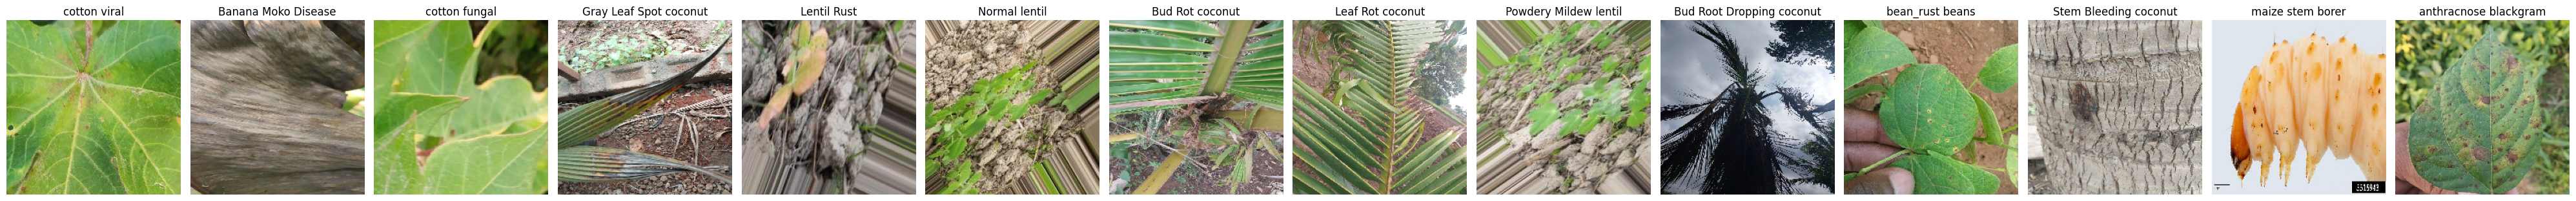

In [5]:
images, labels = next(train_generator)

class_name = train_generator.class_indices

index_to_class_name = {v: k for k, v in class_name.items()}

images_per_class = {}

fig_size = (30, 30)
for i in range(images.shape[0]):
    pred_class_index = labels[i].argmax()
    pred_class = index_to_class_name[pred_class_index]
    if pred_class not in images_per_class:
        images_per_class[pred_class] = images[i]
    if len(images_per_class[pred_class]) == len(class_name):
      break

plt.figure(figsize= (40, 40))
i = 1
for class_name, image in images_per_class.items():
    plt.subplot(1, len(images_per_class), i)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis('off')
    i += 1
plt.tight_layout()
plt.show()


In [6]:
#CNN model training
recognition_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
model_compile = recognition_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
recognition_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 33)             │     2,855,457 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,948,705 (11.25 MB)

 Trainable params: 2,948,705 (11.25 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
device = tf.device('/device:GPU:0')
with device:
  history = recognition_model.fit(
    train_generator, epochs = 10, validation_data = validation_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
155/348 ━━━━━━━━━━━━━━━━━━━━ 47s 245ms/step - accuracy: 0.2646 - loss: 2.5051

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


348/348 ━━━━━━━━━━━━━━━━━━━━ 109s 291ms/step - accuracy: 0.3744 - loss: 2.0773 - val_accuracy: 0.5992 - val_loss: 1.1688
Epoch 2/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 95s 273ms/step - accuracy: 0.7376 - loss: 0.7748 - val_accuracy: 0.6641 - val_loss: 1.0514
Epoch 3/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 97s 277ms/step - accuracy: 0.8328 - loss: 0.4812 - val_accuracy: 0.6216 - val_loss: 1.3793
Epoch 4/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 102s 292ms/step - accuracy: 0.8988 - loss: 0.3006 - val_accuracy: 0.6649 - val_loss: 1.5594
Epoch 5/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 91s 263ms/step - accuracy: 0.9318 - loss: 0.2045 - val_accuracy: 0.6627 - val_loss: 1.9049
Epoch 6/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 89s 257ms/step - accuracy: 0.9513 - loss: 0.1435 - val_accuracy: 0.6472 - val_loss: 2.2861
Epoch 7/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 90s 258ms/step - accuracy: 0.9663 - loss: 0.1003 - val_accuracy: 0.6295 - val_loss: 2.7367
Epoch 8/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 93s 268ms/step - accuracy: 0.9720 - loss: 0.0894 - v

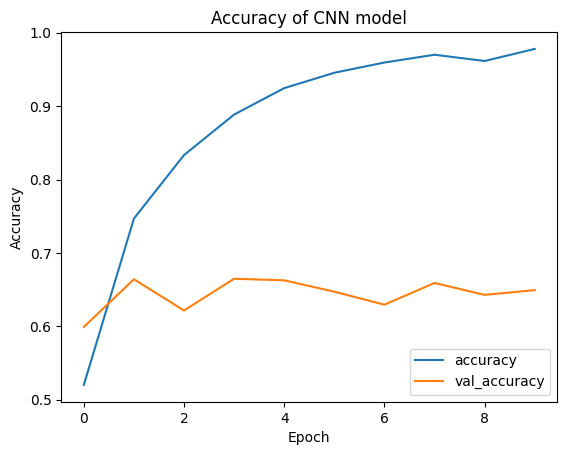

In [9]:
#accuracy and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title("Accuracy of CNN model")
plt.show()

87/87 ━━━━━━━━━━━━━━━━━━━━ 18s 204ms/step


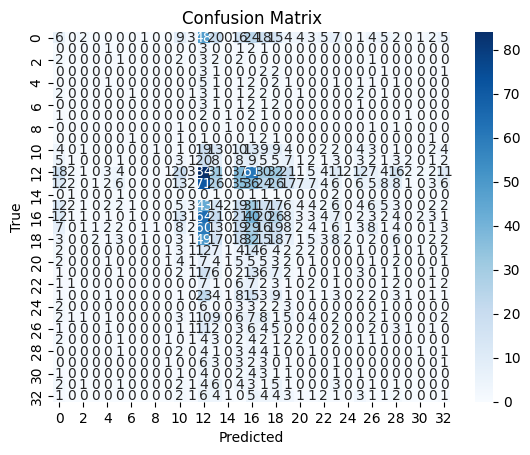

In [14]:
#plot confusion matrix
y_pred = recognition_model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [15]:
#save recognition model
recognition_model.save('disease_recognition_model.keras')